In [ ]:
# Install sentence-transformers and tqdm (required for hybrid embedding cell)
# This cell installs necessary packages for advanced text embeddings in clustering
import sys, subprocess
print('Installing sentence-transformers and tqdm...')
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'sentence-transformers', 'tqdm', '-q'])
print('Dependencies installed.')

Installing sentence-transformers and tqdm...
Dependencies installed.


In [ ]:
# =====================================================
# TRADITIONAL CLUSTERING: TF-IDF + SVD + MiniBatchKMeans
# =====================================================
# This cell performs traditional clustering using TF-IDF for text, SVD for reduction,
# and MiniBatchKMeans for scalable clustering. It evaluates multiple k values and saves results.

# =====================================================
# 1. IMPORTS
# =====================================================
# Import libraries for data processing, vectorization, clustering, and saving
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

import joblib
import warnings
warnings.filterwarnings("ignore")

# =====================================================
# 2. LOAD the CV dataset
# =====================================================
# Load job postings data and handle missing values
df = pd.read_csv("prepared_jobs_dataset.csv")

# Normalize / fill missing text fields
for c in ["skill_text","job_title_short","company_name","CountryName","experience","full_text","clean_text","country"]:
    if c in df.columns:
        df[c] = df[c].fillna("")

# Build a single cleaned text field if not present
if "clean_text" not in df.columns or df["clean_text"].isna().all():
    df["clean_text"] = (
        df["job_title_short"].astype(str) + ' ' +
        df["company_name"].astype(str) + ' ' +
        df["skill_text"].astype(str)
    )

# Numeric features 
df["num_skills"] = df.get("skill_text", "").apply(lambda x: len(str(x).split())) if "skill_text" in df.columns else 0
if "experience" in df.columns:
    df["exp_length"] = df["experience"].apply(lambda x: len(str(x).split()))
else:
    df["exp_length"] = 0


# 3. TEXT VECTORIZATION + SVD (reduced for speed)
# Vectorize text with TF-IDF and reduce dimensions
print("Vectorizing CV text...")
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
X_text = tfidf.fit_transform(df["clean_text"])

print("Reducing text dimensions with SVD...")
svd = TruncatedSVD(n_components=100, random_state=42)
X_text_reduced = svd.fit_transform(X_text)


# 4. CATEGORICAL FEATURES (Country)
# One-hot encode country if available
country_col = "CountryName" if "CountryName" in df.columns else ("country" if "country" in df.columns else None)
if country_col is not None:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    X_country = ohe.fit_transform(df[[country_col]])
else:
    X_country = np.zeros((X_text_reduced.shape[0], 0))
    ohe = None

# 5. NUMERIC FEATURES (Standardized)
# Scale numeric features
num_cols = []
if "num_skills" in df.columns: num_cols.append("num_skills")
if "exp_length" in df.columns: num_cols.append("exp_length")
if len(num_cols):
    scaler = StandardScaler()
    X_num = scaler.fit_transform(df[num_cols])
else:
    X_num = np.zeros((X_text_reduced.shape[0], 0))
    scaler = None


# 6. FINAL FEATURE VECTOR
# Combine all features
if X_country.shape[0] != X_text_reduced.shape[0] or X_num.shape[0] != X_text_reduced.shape[0]:
    raise ValueError('Feature component row counts do not match')

X = np.hstack([X_text_reduced, X_country, X_num])
print("Final feature shape:", X.shape)


# 7. CLUSTERING (KMeans/MiniBatch)
# Test different numbers of clusters and select best by silhouette score
print("Clustering candidates...")

scores = {}
for k in [10, 15, 20, 25, 30]:
    print(f"Testing k={k}...")
    mbk = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=512)
    labels = mbk.fit_predict(X)
    score = silhouette_score(X, labels)
    scores[k] = score
    print(f"  silhouette={score:.4f}")

best_k = max(scores, key=scores.get)
print(f"Best k: {best_k} (score: {scores[best_k]:.4f})")

kmeans = MiniBatchKMeans(
    n_clusters=best_k,
    batch_size=512,
    max_iter=100,
    random_state=42,
    reassignment_ratio=0.01
)

cluster_labels = kmeans.fit_predict(X)
df["cluster"] = cluster_labels

try:
    score = silhouette_score(X, df["cluster"])
    print("Final Silhouette Score:", score)
except Exception as e:
    print("Could not compute silhouette score:", e)


# 8. SAVE ARTIFACTS
# Save model and preprocessing for reuse
joblib.dump(kmeans, "candidate_clusters.joblib")
joblib.dump(tfidf, "tfidf_cv.joblib")
joblib.dump(svd, "svd_cv.joblib")
if ohe is not None:
    joblib.dump(ohe, "ohe_country.joblib")
if scaler is not None:
    joblib.dump(scaler, "scaler_cv.joblib")

df.to_csv("cv_dataset_with_clusters.csv", index=False)

print("\n✔ DONE — CVs segmented successfully!")
print("Clusters saved in: cv_dataset_with_clusters.csv")

Vectorizing CV text...
Reducing text dimensions with SVD...
Final feature shape: (576257, 261)
Clustering candidates...
Testing k=10...
  silhouette=0.1499
Testing k=15...
  silhouette=0.1374
Testing k=20...
  silhouette=0.1635
Testing k=25...
  silhouette=0.1691
Testing k=30...
  silhouette=0.1694
Best k: 30 (score: 0.1694)
Final Silhouette Score: 0.16935049156678963

✔ DONE — CVs segmented successfully!
Clusters saved in: cv_dataset_with_clusters.csv


Loading dataset...
Dataset size: (576257, 10)
Vectorizing text...
Reducing TF-IDF dimensions with SVD...
Final feature shape: (576257, 102)
Clustering with 10 clusters...
Calculating Silhouette Score...
Silhouette Score (sampled): 0.1786

Top keywords per cluster:
Cluster 0: ['access excel', 'access', 'access power', 'airflow ansible', 'access python', 'access snowflake', 'airflow azure', 'airflow aws', 'airflow excel', 'access sas']
Cluster 1: ['access', 'access mysql', 'access oracle', 'access power', 'airflow cassandra', 'airflow aws', 'access powerpoint', 'access vba', 'airflow kafka', 'airflow flow']
Cluster 2: ['access', 'access mysql', 'access sap', 'access python', 'access sql', 'airflow cassandra', 'access snowflake', 'airflow mongodb', 'access power', 'airflow gdpr']
Cluster 3: ['access', 'access python', 'access sap', 'access mysql', 'access sql', 'airflow bigquery', 'airflow cassandra', 'airflow ansible', 'airflow kafka', 'airflow java']
Cluster 4: ['access', 'access mysql'

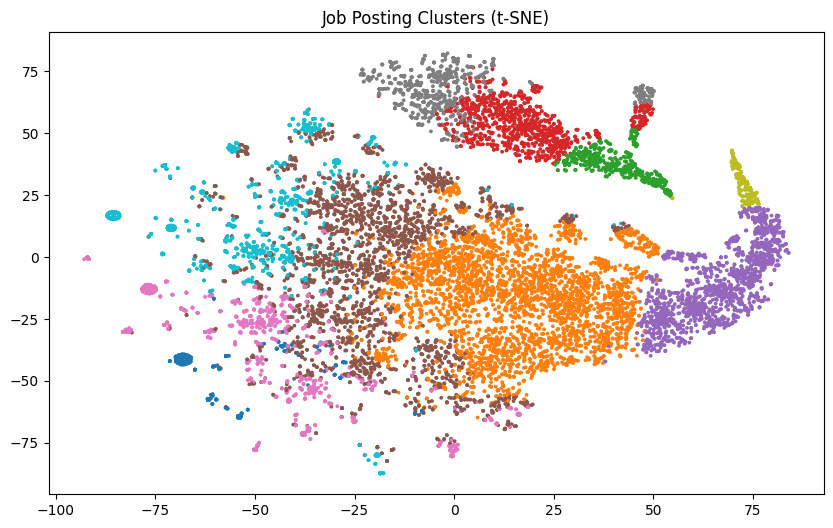


DONE ✔ — Clustering saved to clustered_job_postings.csv


In [ ]:
# ============================================
# ALTERNATIVE CLUSTERING: TF-IDF + SVD + MiniBatchKMeans with Keywords
# ============================================
# This cell provides an alternative clustering approach with keyword extraction for interpretability.
# It uses TF-IDF, SVD, MiniBatchKMeans, extracts top keywords per cluster, visualizes, and saves results.

# ============================================
# 1) IMPORTS
# ============================================
# Import required libraries
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# ============================================
# 2) LOAD & PREPARE DATA
# ============================================
# Load and preprocess data
print("Loading dataset...")
df = pd.read_csv("prepared_jobs_dataset.csv")

df['skill_text'] = df['skill_text'].fillna('')
df['job_title_short'] = df['job_title_short'].fillna('')
df['company_name'] = df['company_name'].fillna('')
df['clean_text'] = df['job_title_short'] + ' ' + df['skill_text']

# Numeric features
df['num_skills'] = df['skill_text'].apply(lambda x: len(x.split()))
df['title_len'] = df['job_title_short'].apply(lambda x: len(x.split()))

print("Dataset size:", df.shape)

# ============================================
# 3) TF-IDF VECTORIZATION
# ============================================
# Vectorize text with TF-IDF
print("Vectorizing text...")
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    stop_words='english',
    token_pattern=r'(?u)\b[a-zA-Z][a-zA-Z]+\b'
)

X_text = tfidf.fit_transform(df['clean_text'])

# ============================================
# 4) DIMENSIONALITY REDUCTION (IMPORTANT)
# ============================================
# Reduce dimensions with SVD
print("Reducing TF-IDF dimensions with SVD...")
svd = TruncatedSVD(n_components=100, random_state=42)
X_text_reduced = svd.fit_transform(X_text)

# ============================================
# 5) NUMERIC FEATURES (SCALED)
# ============================================
# Scale numeric features
scaler = StandardScaler()
X_numeric = scaler.fit_transform(df[['num_skills', 'title_len']])

# ============================================
# 6) FINAL FEATURE MATRIX
# ============================================
# Combine features
X = np.hstack([X_text_reduced, X_numeric])
print("Final feature shape:", X.shape)

# ============================================
# 7) CLUSTERING WITH MiniBatchKMeans
# ============================================
# Perform clustering
n_clusters = 10   # easy, interpretable, fast

print(f"Clustering with {n_clusters} clusters...")
kmeans = MiniBatchKMeans(
    n_clusters=n_clusters,
    batch_size=2048,
    random_state=42
)

df['cluster'] = kmeans.fit_predict(X)

# ============================================
# 8) SILHOUETTE SCORE (SAFE SAMPLING)
# ============================================
# Compute silhouette score on sample
print("Calculating Silhouette Score...")

sample_size = 10000
sample_idx = np.random.choice(len(X), sample_size, replace=False)

sil_score = silhouette_score(
    X[sample_idx],
    df['cluster'].iloc[sample_idx]
)

print(f"Silhouette Score (sampled): {sil_score:.4f}")

# ============================================
# 9) CLUSTER INTERPRETATION (TOP KEYWORDS)
# ============================================
# Extract top keywords for each cluster
print("\nTop keywords per cluster:")

terms = tfidf.get_feature_names_out()
centroids = kmeans.cluster_centers_[:, :100]  # text part only

for i in range(n_clusters):
    top_idx = centroids[i].argsort()[-10:][::-1]
    keywords = [terms[j] for j in top_idx if j < len(terms)]
    print(f"Cluster {i}: {keywords}")

# ============================================
# 10) VISUALIZATION (t-SNE)
# ============================================
# Visualize clusters in 2D
print("Visualizing clusters with t-SNE...")

tsne = TSNE(
    n_components=2,
    perplexity=40,
    learning_rate=200,
    random_state=42
)

X_tsne = tsne.fit_transform(X[:15000])  # limit for speed

plt.figure(figsize=(10,6))
plt.scatter(
    X_tsne[:,0],
    X_tsne[:,1],
    c=df['cluster'][:15000],
    cmap='tab10',
    s=3
)
plt.title("Job Posting Clusters (t-SNE)")
plt.show()

# ============================================
# 11) SAVE RESULTS
# ============================================
# Save model and preprocessors
joblib.dump(kmeans, "kmeans_alt.joblib")
joblib.dump(tfidf, "tfidf_alt.joblib")
joblib.dump(svd, "svd_alt.joblib")
joblib.dump(scaler, "scaler_alt.joblib")
# Save clustered data
df.to_csv("clustered_job_postings.csv", index=False)
print("\nDONE ✔ — Clustering saved to clustered_job_postings.csv")

Batches: 100%|██████████| 2252/2252 [17:18<00:00,  2.17it/s]


Silhouette (UMAP+DBSCAN): 0.0481
Clusters found: 4407


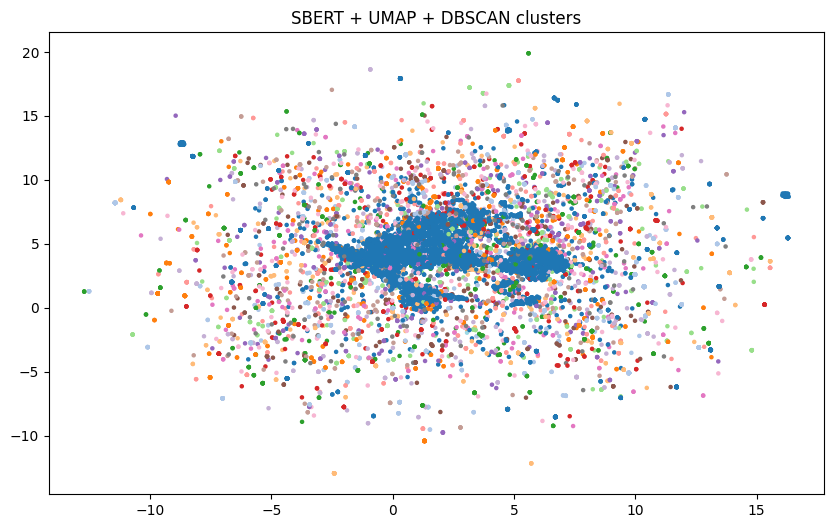

In [ ]:
# SBERT + UMAP + DBSCAN Clustering (Alternative to HDBSCAN)
# This cell uses Sentence-BERT for embeddings, UMAP for reduction, and DBSCAN for density-based clustering.
# DBSCAN is used instead of HDBSCAN to avoid installation issues on Windows.

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import umap
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("prepared_jobs_dataset.csv")
df['skill_text'] = df['skill_text'].fillna('')
df['clean_text'] = df['skill_text']   # IMPORTANT

# Sentence-BERT
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(
    df['clean_text'].tolist(),
    batch_size=256,
    show_progress_bar=True,
    normalize_embeddings=True
)

# UMAP (dimensionality reduction)
umap_model = umap.UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)
X_umap = umap_model.fit_transform(embeddings)

# DBSCAN clustering (density-based, no need for min_cluster_size like HDBSCAN)
clusterer = DBSCAN(
    eps=0.5,  # maximum distance between two samples for one to be considered as in the neighborhood of the other
    min_samples=10,  # minimum number of samples in a neighborhood for a point to be considered as a core point
    metric='euclidean'
)
clusters = clusterer.fit_predict(X_umap)
df['cluster'] = clusters

# Remove noise (-1)
df_clustered = df[df['cluster'] != -1]

# Silhouette (optional, sampled) - only if more than 1 cluster
if df_clustered['cluster'].nunique() > 1:
    sample = df_clustered.sample(min(10000, len(df_clustered)), random_state=42)
    sil = silhouette_score(
        X_umap[sample.index],
        sample['cluster']
    )
    print("Silhouette (UMAP+DBSCAN):", round(sil, 4))
else:
    print("Only one cluster or noise found, silhouette not computed.")

print("Clusters found:", df_clustered['cluster'].nunique())

# Visualization
plt.figure(figsize=(10,6))
plt.scatter(
    X_umap[:20000,0],
    X_umap[:20000,1],
    c=clusters[:20000],
    cmap='tab20',
    s=5
)
plt.title("SBERT + UMAP + DBSCAN clusters")
plt.show()

df_clustered.to_csv("job_clusters_sbert_dbscan.csv", index=False)